In [48]:
import sys
# !{sys.executable} -m pip install altair
# !{sys.executable} -m pip install altair_data_server
# !{sys.executable} -m pip install prince
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow
# !{sys.executable} -m pip install keras
# !{sys.executable} -m pip install scikeras

import pandas as pd
import numpy as np
import altair as alt
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
#alt.data_transformers.enable('data_server')
alt.data_transformers.enable('json') 
import utils

RANDOM_SEED = 42

In [2]:
default_df = pd.read_excel('assets/default of credit card clients.xls', header=1, index_col=0)
default_df.rename(columns={'default payment next month': 'default', 'PAY_0': 'PAY_1'}, inplace=True)
default_df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split

In [4]:
# data transformation
def_cat_df = default_df.copy()
def_cat_df['AGE_GROUP'] = (def_cat_df.AGE / 10).apply(np.floor).astype(int)
def_cat_df['PAY_1_DUE'] = np.where(def_cat_df['PAY_1'] <= 0, 'YES', 'NO')
def_cat_df['PAY_2_DUE'] = np.where(def_cat_df['PAY_2'] <= 0, 'YES', 'NO')
def_cat_df['PAY_3_DUE'] = np.where(def_cat_df['PAY_3'] <= 0, 'YES', 'NO')
def_cat_df['PAY_4_DUE'] = np.where(def_cat_df['PAY_4'] <= 0, 'YES', 'NO')
def_cat_df['PAY_5_DUE'] = np.where(def_cat_df['PAY_5'] <= 0, 'YES', 'NO')
def_cat_df['PAY_6_DUE'] = np.where(def_cat_df['PAY_6'] <= 0, 'YES', 'NO')
def_cat_df = pd.get_dummies(def_cat_df, columns=['PAY_1_DUE', 'PAY_2_DUE', 'PAY_3_DUE', 'PAY_4_DUE', 'PAY_5_DUE', 'PAY_6_DUE'], drop_first=True)
def_cat_df.drop(columns=['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'AGE'], inplace=True)
def_cat_df['SEX'] = np.where(def_cat_df['SEX'] == 1, 'MALE', 'FEMALE')
def_cat_df = pd.get_dummies(def_cat_df, columns=['SEX'], drop_first=True)
def_cat_df = pd.get_dummies(def_cat_df, columns=['EDUCATION', 'MARRIAGE', 'AGE_GROUP'])
def_cat_df.head()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,AGE_GROUP_7
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,3913,3102,689,0,0,0,0,689,0,...,0,1,0,0,1,0,0,0,0,0
2,120000,2682,1725,2682,3272,3455,3261,0,1000,1000,...,0,0,1,0,1,0,0,0,0,0
3,90000,29239,14027,13559,14331,14948,15549,1518,1500,1000,...,0,0,1,0,0,1,0,0,0,0
4,50000,46990,48233,49291,28314,28959,29547,2000,2019,1200,...,0,1,0,0,0,1,0,0,0,0
5,50000,8617,5670,35835,20940,19146,19131,2000,36681,10000,...,0,1,0,0,0,0,0,1,0,0


### Add in additional variables
- Indicator whether a user make all the payment continuously on all month derived from all Pay_x variables.

In [5]:
def_cat_df_added=def_cat_df.copy()
def_cat_df_added['Continuouse Indicator']=np.where((def_cat_df_added.PAY_AMT1>0) & (def_cat_df_added.PAY_AMT2>0)&(def_cat_df_added.PAY_AMT3>0)&(def_cat_df_added.PAY_AMT4>0)&(def_cat_df_added.PAY_AMT5>0)&(def_cat_df_added.PAY_AMT6>0), 
   "YES", 
   "NO")

def_cat_df_added = pd.get_dummies(def_cat_df_added, columns=['Continuouse Indicator'], drop_first=True)

## Random Forest Classifier experiment

In [6]:
RANDOM_SEED = 42
X = def_cat_df.drop(columns=['default'])
y = def_cat_df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

rf_clf = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Random Forest Classifier', clsf=rf_clf, X_test=X_test, y_test=y_test)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5470,403
Negative (actual),1052,575


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.59,0.35,0.44,0.75


alt.HConcatChart(...)

Let's add the newly added variable and see the performance.

In [7]:
RANDOM_SEED = 42
X = def_cat_df_added.drop(columns=['default'])
y = def_cat_df_added['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

rf_clf = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Random Forest Classifier', clsf=rf_clf, X_test=X_test, y_test=y_test)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5478,395
Negative (actual),1047,580


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.59,0.36,0.45,0.76


alt.HConcatChart(...)

## Let's use grid-search together with cross validation to find the best parameters for Random Forest Classifier.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#First, let's split the training data and testing data into equally two parts, and one used for in grid-search, and one used for cross validation to avoid data leakage.
RANDOM_SEED = 42
X = def_cat_df_added.drop(columns=['default'])
y = def_cat_df_added['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED)



#Let's create the list of hyper-parameters that we would like to tune

# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [int(x) for x in np.linspace(start = 5, stop = 100, num = 5)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth}
               #,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}


rf_clf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rd_gridcv= GridSearchCV(rf_clf, random_grid, scoring = 'f1', cv = 5,n_jobs=-1)
#rf_random = RandomizedSearchCV(estimator = rf_clf, param_distributions = RANDOM_SEED, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rd_gridcv.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(rd_gridcv.best_params_)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, rd_gridcv.predict(X_test)
print(classification_report(y_true, y_pred))
print()
print("The model f1 score is:")
f1_score(y_true, y_pred)

Best parameters set found on development set:
{'max_depth': 30, 'max_features': 'auto', 'n_estimators': 76}
The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.84      0.94      0.88     11725
           1       0.61      0.35      0.45      3275

    accuracy                           0.81     15000
   macro avg       0.72      0.65      0.67     15000
weighted avg       0.79      0.81      0.79     15000


The model f1 score is:


0.4473126565209016

## Gradient Boosting Classifier experiment (all features)

In [9]:
X = def_cat_df.drop(columns=['default'])
y = def_cat_df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

gbc = GradientBoostingClassifier(max_depth=8, random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Gradient Boosting Classifier', clsf=gbc, X_test=X_test, y_test=y_test)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5465,408
Negative (actual),1017,610


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.6,0.37,0.46,0.76


alt.HConcatChart(...)

## Gradient Boosting Classifier experiment (all features +new created feature)

In [10]:
X = def_cat_df_added.drop(columns=['default'])
y = def_cat_df_added['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

gbc = GradientBoostingClassifier(max_depth=8, random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Gradient Boosting Classifier', clsf=gbc, X_test=X_test, y_test=y_test)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5474,399
Negative (actual),1028,599


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.6,0.37,0.46,0.76


alt.HConcatChart(...)

## Gradient Boosting Classifier experiment (high importance features only)

In [11]:
## Let's now remove features with low importance and re-run model training on features with higher importance

low_imp_feat = ['SEX_MALE', 'MARRIAGE_0', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3',
                    'EDUCATION_0', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4',
                    'EDUCATION_5', 'EDUCATION_6', 'AGE_GROUP_2', 'AGE_GROUP_3', 'AGE_GROUP_4', 'AGE_GROUP_5', 'AGE_GROUP_6', 'AGE_GROUP_7']

X = def_cat_df.drop(columns=['default'] + low_imp_feat)
y = def_cat_df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

gbc_high_imp = GradientBoostingClassifier(max_depth=8, random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Gradient Boosting Classifier (high importance features)', clsf=gbc_high_imp, X_test=X_test, y_test=y_test)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5470,403
Negative (actual),1025,602


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.6,0.37,0.46,0.76


alt.HConcatChart(...)

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
#First, let's split the training data and testing data into equally two parts, and one used for in grid-search, and one used for cross validation to avoid data leakage.
RANDOM_SEED = 42
X = def_cat_df_added.drop(columns=['default'])
y = def_cat_df_added['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=RANDOM_SEED)



#Let's create the list of hyper-parameters that we would like to tune

# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start = 5, stop = 50, num = 3)]
# Number of features to consider at every split
learning_rate= [0.01, 0.05,  0.1]
subsample=[0.5, 0.7, 1.0]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 15, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
# min_samples_split = [2, 4, 8]
# Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'subsample':subsample,
               'learning_rate':learning_rate}
               
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,



gb_clf = GradientBoostingClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_gridcv= GridSearchCV(gb_clf, grid, scoring = 'f1', cv = 5,n_jobs=-1)
# Fit the random search model
gb_gridcv.fit(X_train, y_train)
print("Best parameters set found on development set:")
print(gb_gridcv.best_params_)

print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_test, gb_gridcv.predict(X_test)
print(classification_report(y_true, y_pred))
print()
print("The model f1 score is:")
f1_score(y_true, y_pred)

Best parameters set found on development set:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'subsample': 1.0}
The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

           0       0.84      0.94      0.89     11725
           1       0.62      0.38      0.47      3275

    accuracy                           0.81     15000
   macro avg       0.73      0.66      0.68     15000
weighted avg       0.80      0.81      0.80     15000


The model f1 score is:


0.4698267656577194

## XGBoost Classifier experiment

In [13]:
def_cat_df = def_cat_df.astype(int)
X = def_cat_df.drop(columns=['default'])
y = def_cat_df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)
xgbc = XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=RANDOM_SEED, gamma=0.25).fit(X_train, y_train)

utils.get_classifier_summary('XGBoost Classifier', xgbc, X_test=X_test, y_test=y_test)

[15:00:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),5479,394
Negative (actual),1027,600


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.6,0.37,0.46,0.76


alt.HConcatChart(...)

## Neural Network classifier experiment

In [14]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential

numeric_cols = ['LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
                'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

def_cat_df = def_cat_df.astype(int)
X = def_cat_df.drop(columns=['default'])
y = def_cat_df['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

scaler = StandardScaler()
# scaler.fit(X)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)
scaler.fit(X[numeric_cols])
X_train_num_scaled = scaler.transform(X_train[numeric_cols])
X_train = np.concatenate([X_train_num_scaled, X_train.drop(columns=numeric_cols).to_numpy()], axis=1)
X_test_num_scaled = scaler.transform(X_test[numeric_cols])
X_test = np.concatenate([X_test_num_scaled, X_test.drop(columns=numeric_cols).to_numpy()], axis=1)

def create_model():
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dropout(0.2, seed=RANDOM_SEED))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)
model.fit(X_train, y_train, validation_data=(X_test, y_test))

<ipython-input-14-9d9de0d0b32a>:34: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=1)


Epoch 1/20
704/704 [==============================] - 2s 1ms/step - loss: 0.5016 - accuracy: 0.7791 - val_loss: 0.4486 - val_accuracy: 0.8019
Epoch 2/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4593 - accuracy: 0.8045 - val_loss: 0.4444 - val_accuracy: 0.8032
Epoch 3/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4519 - accuracy: 0.8057 - val_loss: 0.4439 - val_accuracy: 0.8040
Epoch 4/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4493 - accuracy: 0.8064 - val_loss: 0.4414 - val_accuracy: 0.8053
Epoch 5/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4494 - accuracy: 0.8066 - val_loss: 0.4409 - val_accuracy: 0.8060
Epoch 6/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4468 - accuracy: 0.8091 - val_loss: 0.4398 - val_accuracy: 0.8047
Epoch 7/20
704/704 [==============================] - 1s 1ms/step - loss: 0.4453 - accuracy: 0.8083 - val_loss: 0.4385 - val_accuracy: 0.8048
Epoch 

## Testing models and feature (scaling)

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
temp_df = default_df.copy()
temp_X_df = temp_df.drop('default',axis=1)
temp_y_df = temp_df[['default']]

In [17]:
train_df, val_df, test_df = np.split(temp_df.sample(frac=1,random_state=RANDOM_SEED), [int(.6*len(temp_df)), int(.8*len(temp_df))])

X_train, y_train = train_df.drop('default', axis=1), train_df['default']
X_val, y_val = val_df.drop('default', axis=1), val_df['default']
X_test, y_test = test_df.drop('default', axis=1), test_df['default']


In [28]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_X_val = pd.DataFrame(scaler.transform(X_val), index=X_val.index, columns=X_val.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [29]:
rf_clf = RandomForestClassifier(random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Random Forest Classifier', clsf=rf_clf, X_test=X_val, y_test=y_val)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),4366,244
Negative (actual),874,516


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.81,0.68,0.37,0.48,0.77


alt.HConcatChart(...)

In [30]:
gb_clf = GradientBoostingClassifier(max_depth=8, random_state=RANDOM_SEED).fit(X_train, y_train)

utils.get_classifier_summary(clsf_type='Gradient Boosting Classifier', clsf=gb_clf, X_test=X_val, y_test=y_val)

alt.Chart(...)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),4374,236
Negative (actual),867,523


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.82,0.69,0.38,0.49,0.77


alt.HConcatChart(...)

In [31]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

In [32]:
lr = LogisticRegression(random_state=RANDOM_SEED,solver='lbfgs', max_iter=3000).fit(X_train,y_train)
gnb = GaussianNB().fit(X_train,y_train)
svc = LinearSVC(random_state=RANDOM_SEED, max_iter=3000,dual=False).fit(X_train,y_train)

scaled_lr = LogisticRegression(random_state=RANDOM_SEED,solver='lbfgs', max_iter=3000).fit(scaled_X_train,y_train)
scaled_gnb = GaussianNB().fit(scaled_X_train,y_train)
scaled_svc = LinearSVC(random_state=RANDOM_SEED, max_iter=3000,dual=False).fit(scaled_X_train,y_train)

In [33]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, \
    precision_recall_curve

def get_classifier_summary(clsf_type, clsf, X_test, y_test):

    y_predicted = clsf.predict(X_test)
    confusion = confusion_matrix(y_test, y_predicted)
    confusion_df = pd.DataFrame(data=confusion, columns=['Positive (predicted)', 'Negative (predicted)'],
                                index=['Positive (actual)', 'Negative (actual)'])
    print('Confusion matrix')
    display(confusion_df)

    y_pred_proba = clsf.predict_proba(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    metrics_df = pd.DataFrame(data={'Accuracy': [accuracy_score(y_test, y_predicted)],
                                    'Precision': [precision_score(y_test, y_predicted)],
                                    'Recall': [recall_score(y_test, y_predicted)],
                                    'F1 score': [f1_score(y_test, y_predicted)],
                                    'ROC AUC': [roc_auc]})

    print('Classifier metrics')
    display(metrics_df.round(2))

    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba[:, 1])
    plot_metrics(fpr=fpr, tpr=tpr, prec=precision, rec=recall)

def plot_metrics(fpr, tpr, prec, rec):
    roc_df = pd.DataFrame(data={'fpr': fpr, 'tpr': tpr})
    prec_rec_df = pd.DataFrame(data={'prec': prec, 'rec': rec})
    line_df = pd.DataFrame({'fpr': [0, 1], 'tpr': [0, 1]})

    roc_ch = alt.Chart(data=roc_df, title='ROC curve').mark_line().encode(
        x=alt.X('fpr:Q', title='False Positive Rate'),
        y=alt.Y('tpr:Q', title='True Positive Rate')
    ).properties(width=250, height=300)

    line_ch = alt.Chart(data=line_df).mark_line(strokeWidth=0.5, strokeDash=[5, 5]).encode(
        x=alt.X('fpr:Q'),
        y=alt.Y('tpr:Q')
    )

    prec_rec_ch = alt.Chart(data=prec_rec_df, title='Precision-Recall curve').mark_line().encode(
        x=alt.X('prec:Q', title='Precision'),
        y=alt.Y('rec:Q', title='Recall')
    ).properties(width=250, height=300)

    ((roc_ch + line_ch) | prec_rec_ch).display()

In [34]:
get_classifier_summary(clsf_type='Logistic Regression', clsf=lr, X_test=X_val, y_test=y_val)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),4609,1
Negative (actual),1390,0


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.77,0.0,0.0,0.0,0.63


alt.HConcatChart(...)

In [35]:
get_classifier_summary(clsf_type='Gaussian NB', clsf=gnb, X_test=X_val, y_test=y_val)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),1280,3330
Negative (actual),213,1177


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.41,0.26,0.85,0.4,0.66


alt.HConcatChart(...)

In [36]:
get_classifier_summary(clsf_type='Scaled Logistic Regression', clsf=lr, X_test=scaled_X_val, y_test=y_val)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),2110,2500
Negative (actual),620,770


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.48,0.24,0.55,0.33,0.53


alt.HConcatChart(...)

In [37]:
get_classifier_summary(clsf_type='Scaled Gaussian NB', clsf=gnb, X_test=scaled_X_val, y_test=y_val)

Confusion matrix


,Positive (predicted),Negative (predicted)
Positive (actual),0,4610
Negative (actual),0,1390


Classifier metrics


,Accuracy,Precision,Recall,F1 score,ROC AUC
0,0.23,0.23,1.0,0.38,0.67


alt.HConcatChart(...)

## Next, we will also predict the payment amount.

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [39]:
X = def_cat_df.drop(columns=['PAY_AMT6','default'])
y = def_cat_df['PAY_AMT6']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_SEED)

In [40]:
scaler = StandardScaler().fit(X_train)
scaled_X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

In [41]:
mlr = LinearRegression()  
mlr.fit(X_train, y_train)
y_pred_mlr= mlr.predict(X_test)

In [42]:
print("Intercept: ", mlr.intercept_)
print("Coefficients:")
list(zip(X, mlr.coef_))

Intercept:  -825.5705368914623
Coefficients:


[('LIMIT_BAL', 0.01638948230548304),
 ('BILL_AMT1', 0.04948137827346114),
 ('BILL_AMT2', -0.025462191635575733),
 ('BILL_AMT3', 0.015450371506996163),
 ('BILL_AMT4', 0.03121542131315374),
 ('BILL_AMT5', 0.11622303900026644),
 ('BILL_AMT6', -0.18912626569606578),
 ('PAY_AMT1', 0.11914007557074958),
 ('PAY_AMT2', 0.004026110768710582),
 ('PAY_AMT3', 0.05199007066585481),
 ('PAY_AMT4', 0.08584045749492879),
 ('PAY_AMT5', 0.20994609804585196),
 ('PAY_1_DUE_YES', 1049.1157728369778),
 ('PAY_2_DUE_YES', -1318.432841690928),
 ('PAY_3_DUE_YES', 518.4387622794083),
 ('PAY_4_DUE_YES', -379.5297801218589),
 ('PAY_5_DUE_YES', -46.34319652410154),
 ('PAY_6_DUE_YES', -440.6965850842419),
 ('SEX_MALE', 130.08084266178398),
 ('EDUCATION_0', -3102.6004795067693),
 ('EDUCATION_1', -140.24954672474885),
 ('EDUCATION_2', 83.77721342483427),
 ('EDUCATION_3', -59.442434489638714),
 ('EDUCATION_4', -2646.8799273505847),
 ('EDUCATION_5', -744.2276684007932),
 ('EDUCATION_6', 6609.622843063065),
 ('MARRIAGE_0'

In [43]:
from sklearn import metrics
import statsmodels.api as sm
meanAbErr = metrics.mean_absolute_error(y_test, y_pred_mlr)
meanSqErr = metrics.mean_squared_error(y_test, y_pred_mlr)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred_mlr))
print('R squared: {:.2f}'.format(mlr.score(X,y)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: 14.38
Mean Absolute Error: 5508.170377917928
Mean Square Error: 287474144.3455034
Root Mean Square Error: 16955.06249901496


In [44]:
X = sm.add_constant(X) # adding a constant
lm = sm.OLS(y, X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PAY_AMT6   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     154.8
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:06:28   Log-Likelihood:            -3.3378e+05
No. Observations:               30000   AIC:                         6.676e+05
Df Residuals:                   29966   BIC:                         6.679e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -202.5060    758.629     -0.267      0.790   -1689.452    1284.440
LIMIT_BAL         0.0164      0.001     18.582      0.000       0.015       0.018
BILL_AMT1         0.0476      0.005      9.872      0.000       0.038       0.057
BILL_AMT2        -0.0281      0.007     -4.155      0.000      -0.041      -0.015
BILL_AMT3         0.0165      0.006      2.591      0.010       0.004       0.029
BILL_AMT4         0.0355      0.007      5.346      0.000       0.022       0.049
BILL_AMT5         0.1462      0.008     18.863      0.000       0.131       0.161
BILL_AMT6        -0.2223      0.006    -36.795      0.000      -0.234      -0.210
PAY_AMT1          0.1055      0.007     14.152      0.000       0.091       0.120
PAY_AMT2          0.0239      0.006      3.891      0.000       0.012       0.036
PAY_AMT3          0.0466      0.007      6.554      0.000       0.033       0.061
PAY_AMT4          0.0762      0.008      9.841      0.000       0.061       0.091
PAY_AMT5          0.2354      0.008     29.606      0.000       0.220       0.251
PAY_1_DUE_YES  1096.7853    307.371      3.568      0.000     494.326    1699.245
PAY_2_DUE_YES -1367.1232    423.331     -3.229      0.001   -2196.871    -537.376
PAY_3_DUE_YES   473.2682    402.310      1.176      0.239    -315.277    1261.814
PAY_4_DUE_YES  -454.3923    448.295     -1.014      0.311   -1333.070     424.285
PAY_5_DUE_YES  -109.4689    498.734     -0.219      0.826   -1087.008     868.071
PAY_6_DUE_YES  -596.4561    427.972     -1.394      0.163   -1435.301     242.388
SEX_MALE          7.0615    196.175      0.036      0.971    -377.449     391.572
EDUCATION_0   -3073.0466   3845.617     -0.799      0.424   -1.06e+04    4464.528
EDUCATION_1    -156.2575    706.645     -0.221      0.825   -1541.311    1228.796
EDUCATION_2     -27.3448    701.608     -0.039      0.969   -1402.526    1347.836
EDUCATION_3    -186.2227    718.791     -0.259      0.796   -1595.084    1222.638
EDUCATION_4   -2908.3611   1452.524     -2.002      0.045   -5755.371     -61.351
EDUCATION_5     258.7949   1093.815      0.237      0.813   -1885.130    2402.720
EDUCATION_6    5889.9319   2100.977      2.803      0.005    1771.926       1e+04
MARRIAGE_0     -813.1122   1791.464     -0.454      0.650   -4324.459    2698.235
MARRIAGE_1      160.8853    547.059      0.294      0.769    -911.373    1233.144
MARRIAGE_2      627.6894    552.905      1.135      0.256    -456.028    1711.407
MARRIAGE_3     -177.9685    880.444     -0.202      0.840   -1903.678    1547.741
AGE_GROUP_2     183.7620    556.995      0.330      0.741    -907.973    1275.497
AGE_GROUP_3     360.5166    543.368      0.663      0.507    -704.507    1425.541
AGE_GROUP_4     190.6480    551.851      0.345      0.730    -891.004    1272.300
AGE_GROUP_5    -165.1518    597.208     -0.277   

In [45]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               PAY_AMT6   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     154.8
Date:                Mon, 24 Jan 2022   Prob (F-statistic):               0.00
Time:                        15:06:28   Log-Likelihood:            -3.3378e+05
No. Observations:               30000   AIC:                         6.676e+05
Df Residuals:                   29966   BIC:                         6.679e+05
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -202.5060    758.629     -0.267      0.790   -1689.452    1284.440
LIMIT_BAL         0.0164      0.001     18.582      0.000       0.015       0.018
BILL_AMT1         0.0476      0.005      9.872      0.000       0.038       0.057
BILL_AMT2        -0.0281      0.007     -4.155      0.000      -0.041      -0.015
BILL_AMT3         0.0165      0.006      2.591      0.010       0.004       0.029
BILL_AMT4         0.0355      0.007      5.346      0.000       0.022       0.049
BILL_AMT5         0.1462      0.008     18.863      0.000       0.131       0.161
BILL_AMT6        -0.2223      0.006    -36.795      0.000      -0.234      -0.210
PAY_AMT1          0.1055      0.007     14.152      0.000       0.091       0.120
PAY_AMT2          0.0239      0.006      3.891      0.000       0.012       0.036
PAY_AMT3          0.0466      0.007      6.554      0.000       0.033       0.061
PAY_AMT4          0.0762      0.008      9.841      0.000       0.061       0.091
PAY_AMT5          0.2354      0.008     29.606      0.000       0.220       0.251
PAY_1_DUE_YES  1096.7853    307.371      3.568      0.000     494.326    1699.245
PAY_2_DUE_YES -1367.1232    423.331     -3.229      0.001   -2196.871    -537.376
PAY_3_DUE_YES   473.2682    402.310      1.176      0.239    -315.277    1261.814
PAY_4_DUE_YES  -454.3923    448.295     -1.014      0.311   -1333.070     424.285
PAY_5_DUE_YES  -109.4689    498.734     -0.219      0.826   -1087.008     868.071
PAY_6_DUE_YES  -596.4561    427.972     -1.394      0.163   -1435.301     242.388
SEX_MALE          7.0615    196.175      0.036      0.971    -377.449     391.572
EDUCATION_0   -3073.0466   3845.617     -0.799      0.424   -1.06e+04    4464.528
EDUCATION_1    -156.2575    706.645     -0.221      0.825   -1541.311    1228.796
EDUCATION_2     -27.3448    701.608     -0.039      0.969   -1402.526    1347.836
EDUCATION_3    -186.2227    718.791     -0.259      0.796   -1595.084    1222.638
EDUCATION_4   -2908.3611   1452.524     -2.002      0.045   -5755.371     -61.351
EDUCATION_5     258.7949   1093.815      0.237      0.813   -1885.130    2402.720
EDUCATION_6    5889.9319   2100.977      2.803      0.005    1771.926       1e+04
MARRIAGE_0     -813.1122   1791.464     -0.454      0.650   -4324.459    2698.235
MARRIAGE_1      160.8853    547.059      0.294      0.769    -911.373    1233.144
MARRIAGE_2      627.6894    552.905      1.135      0.256    -456.028    1711.407
MARRIAGE_3     -177.9685    880.444     -0.202      0.840   -1903.678    1547.741
AGE_GROUP_2     183.7620    556.995      0.330      0.741    -907.973    1275.497
AGE_GROUP_3     360.5166    543.368      0.663      0.507    -704.507    1425.541
AGE_GROUP_4     190.6480    551.851      0.345      0.730    -891.004    1272.300
AGE_GROUP_5    -165.1518    597.208     -0.277   

## Let's try SVR (support vector regression)

In [50]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [52]:
meanAbErr = metrics.mean_absolute_error(y_test, y_pred)
meanSqErr = metrics.mean_squared_error(y_test, y_pred)
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
print('R squared: {:.2f}'.format(regressor.score(X_test,y_test)*100))
print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print('Root Mean Square Error:', rootMeanSqErr)

R squared: -2.14
Mean Absolute Error: 4490.780202086819
Mean Square Error: 347283084.1738795
Root Mean Square Error: 18635.532838474985


### Try Gradient Boosting regression

In [87]:
from sklearn import datasets, ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [69]:
parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]
                 }
GBR = GradientBoostingRegressor()
grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)
grid_GBR.fit(X_train, y_train)
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 GradientBoostingRegressor(learning_rate=0.01, max_depth=10, subsample=0.2)

 The best score across ALL searched params:
 0.1243232510925179

 The best parameters across ALL searched params:
 {'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.2}


In [76]:
params = {
    "n_estimators": 100,
    "max_depth": 10,
    "subsample": 0.2,
    "learning_rate": 0.01
}
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.01, max_depth=10, subsample=0.2)

In [88]:
mse = mean_squared_error(y_test, reg.predict(X_test))
r2=r2_score(y_test,reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))
print("The mean squared error (MSE) on test set: {:.4f}".format(r2))

The mean squared error (MSE) on test set: 297949833.8483
The mean squared error (MSE) on test set: 0.1237


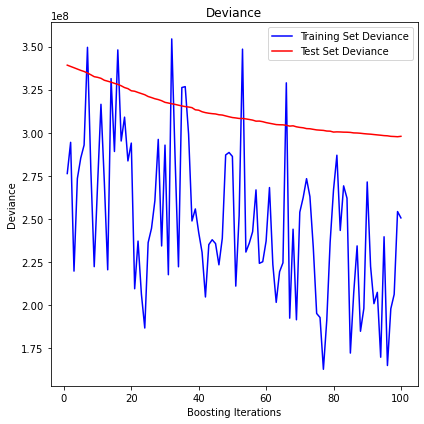

In [86]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = reg.loss_(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

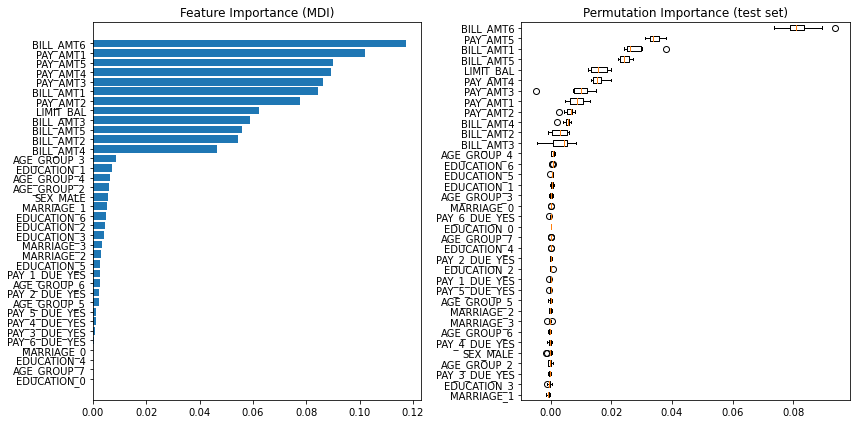

In [75]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(X_train.columns)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()